# This notebook is to perform ML on embedded subnetworks and use the important features to find critical genes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
import os
from src.eda.process_phenotype import *
from src.eda.eda_functions import gene_set_phenotype_corr, run_kmeans, cluster_phenotype_corr, plot_dist
from src.models.feature_extraction import *
from src.models.ML_functions import *
from scipy.stats import f_oneway
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

# Load embedding dfs

### Docker Machine learning models

In [9]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/embedding_derived/embedding_Feb16/embedded_ggvec_epoch=100_alpha=0.1.csv'
emb_df = pd.read_csv(embedding_path, index_col = 0)
emb_name = 'epoch=100_alpha=0.1'
kmeans = run_kmeans(emb_df, 10)

Wall time: 1.84 s


In [126]:
deseq = pd.read_excel(prefix +'/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [12]:
%%time
# process embedding to be ready for ML
processed_emb_df = process_emb_for_ML(emb_df, deseq)

Wall time: 22.8 ms


# Run ML on each embedding (5 embedding total), 3 models each and each model was repeated 3 times so a total of 5 x 3 x 3 = 45 results

### Docker Machine learning models

lr average: 56 ;  rf average: 78 ;  xgb_average: 76


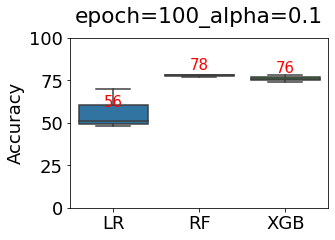

In [128]:
model_weights = run_ml(processed_emb_df, emb_name = emb_name, print_accuracy = True)

# Getting the feature importances and the dimensions that make up 20% of feature importances

### Docker Feature Extraction

In [129]:
top_dim = plot_feature_importances(model_weights, top_n_coef = 0.5, print_num_dim = False, plot_heatmap = False, return_top_dim = True)

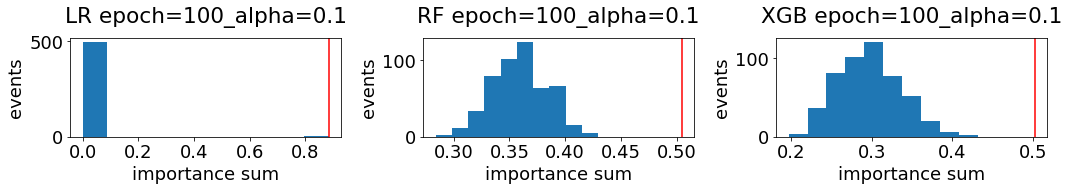

In [7]:
plot_random_feature_importance(model_weights, top_dim, emb_name)

## Determine jaccard similarity between the "important dimensions" for the repeats of the model

### Docker Feature Extraction

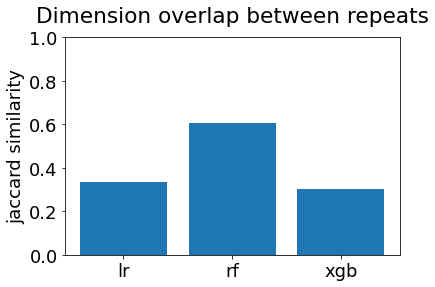

In [130]:
jaccard_average(top_dim, 'Dimension overlap between repeats')

# Identify critical genes from the parameters used (3 models, 3 repeats)

### Docker Critical Gene Identifier

In [9]:
output_dir = prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/'

In [25]:
%%time
gene_set = get_critical_gene_sets(processed_emb_df, top_dim, deseq = deseq)
critical_gene_df = get_critical_gene_df(gene_set, emb_name, output_dir)

Wall time: 3min 35s


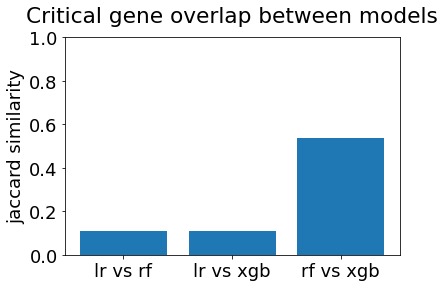

In [131]:
intersect_genes = jaccard_critical_genes(critical_gene_df, 'Critical gene overlap between models')

## Plot correlation of sets of critical genes found in common in 3 models for each embedding

### Module DE/ Diagnostic Correlation (second one)

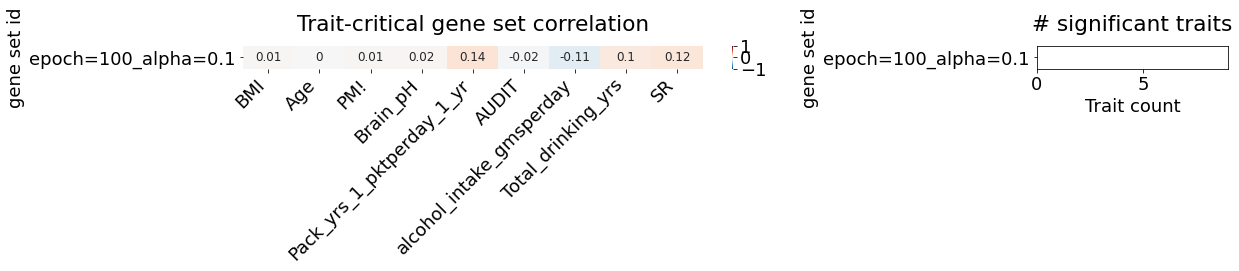

In [27]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)
gene_set_phenotype_corr([intersect_genes], [emb_name], expression_meta_df, 'intersect genes between 3 models')

## Plot number of nearby impact genes to the critical genes. 1 figure per embedding

### Docker Critical Gene Identifier

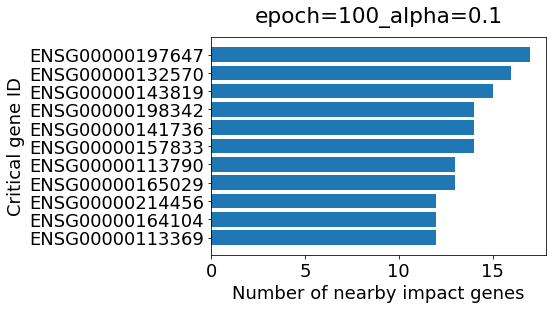

In [31]:
critical_gene_set2 = plot_nearby_impact_num(critical_gene_df, emb_name)

In [91]:
critical_gene_df.head()

,gene,LR_repeat1,LR_repeat2,LR_repeat3,RF_repeat1,RF_repeat2,RF_repeat3,XGB_repeat1,XGB_repeat2,XGB_repeat3,near_impact_cnt
0,ENSG00000197647,0.0,0.0,3.0,2.0,2.0,2.0,3.0,2.0,3.0,17.0
1,ENSG00000132570,1.0,1.0,2.0,4.0,2.0,2.0,1.0,2.0,1.0,16.0
2,ENSG00000143819,0.0,0.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,15.0
3,ENSG00000157833,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,14.0
4,ENSG00000141736,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,14.0


In [74]:
processed_important_emb_df = processed_emb_df[top_dim[0]]
pairwise_distances = pd.DataFrame(ed(processed_important_emb_df.iloc[:, :-2]))
pairwise_distances.columns = processed_emb_df['id']
pairwise_distances.index = processed_emb_df['id']
pairwise_distances['abs_log2FC'] = processed_emb_df['abs_log2FC'].tolist()
pairwise_distances.sort_values('abs_log2FC', ascending = False, inplace=True)

In [77]:
pairwise_distances[['ENSG00000197647','abs_log2FC']]

id,ENSG00000197647,abs_log2FC
id,,
ENSG00000196169,0.397458,3.122151e-01
ENSG00000166819,0.192509,2.899217e-01
ENSG00000138741,0.323646,2.857375e-01
ENSG00000096060,0.259011,2.799149e-01
ENSG00000139144,0.259032,2.782902e-01
...,...,...
ENSG00000025156,0.269634,2.250564e-05
ENSG00000102934,0.580837,1.045304e-05
ENSG00000153395,0.333894,9.038551e-06


In [83]:
pairwise_distances[(pairwise_distances['ENSG00000197647'] < 0.2) & (pairwise_distances['abs_log2FC'] > 0.2)]['ENSG00000197647'].index

Index(['ENSG00000166819', 'ENSG00000116717', 'ENSG00000113369',
       'ENSG00000074410', 'ENSG00000110492', 'ENSG00000164104',
       'ENSG00000111405'],
      dtype='object', name='id')

In [124]:
def plot_critical_gene_2D(dim1, dim2, pairwise_distance_df, critical_gene, distance = 0.15, de_cutoff = 0.2):
    plt.scatter(emb_df[dim1], emb_df[dim2], color = 'lightgrey', s = 2)
    i = 0
    for gene in pairwise_distance_df[(pairwise_distance_df[critical_gene] < distance) & (pairwise_distance_df['abs_log2FC'] > de_cutoff)][critical_gene].index:
        plt.scatter(emb_df.loc[gene, dim1], emb_df.loc[gene, dim2], s = 100, color = 'b', label="DEG" if i == 0 else "")
        i += 1
    plt.scatter(emb_df.loc[critical_gene, dim1], emb_df.loc[critical_gene, dim2], color = 'r', s = 200, marker = '*', label = 'CG')
    plt.legend()
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')

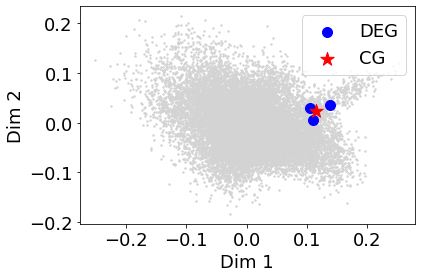

In [125]:
plot_critical_gene_2D('12','50', pairwise_distances, 'ENSG00000132570', distance = 0.08, de_cutoff = 0.15)

In [ ]:
plt.scatter(emb_df['12'], emb_df['50'], color = 'lightgrey', s = 2)
for gene in pairwise_distances[(pairwise_distances['ENSG00000132570'] < 0.1) & (pairwise_distances['abs_log2FC'] > 0.2)]['ENSG00000132570'].index:
    plt.scatter(emb_df.loc[gene, '12'], emb_df.loc[gene, '50'], s = 5, color = 'b')
plt.scatter(emb_df.loc['ENSG00000132570', '12'], emb_df.loc['ENSG00000132570', '50'], color = 'r', s = 30, marker = '*')

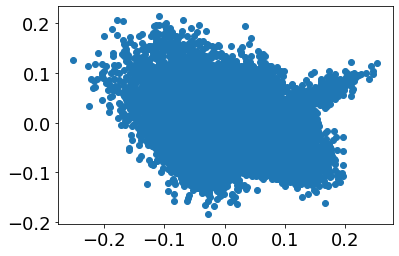

In [26]:
plt.scatter(emb_df['12'], emb_df['50'])

## Plot each set of critical genes and their correlation with alcohol traits. Each gene set is from 1 embedding

### Module DE/ Diagnostic Correlation (second one)

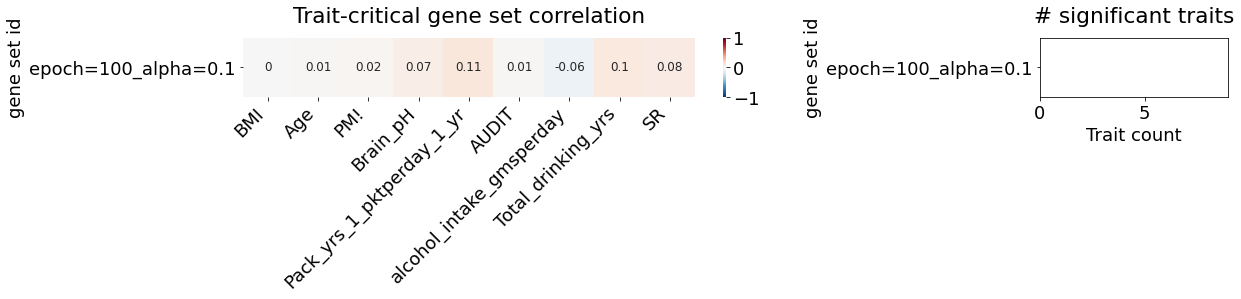

In [34]:
# Plot correlation of top critical genes (with most nearby impact genes) for each embedding
gene_set_phenotype_corr([critical_gene_set2], [emb_name], expression_meta_df, 'top 10 genes')

# Gene ID conversion

In [2]:
gene_mapping_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/gene_mapping_df.csv')

In [3]:
critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/epoch=100_alpha=0.1_critical_gene_df.csv')

In [57]:
gene_mapping_df.head()

,id,symbol
0,ENSG00000227232,WASH7P
1,ENSG00000237683,NaN
2,ENSG00000241860,AL627309.5
3,ENSG00000228463,AP006222.1
4,ENSG00000225972,MTND1P23


In [6]:
gene_mapping_dict = pd.Series(gene_mapping_df['symbol'].values, index = gene_mapping_df['id']).to_dict()

In [7]:
converted_cg_df = critical_gene_df.copy()
converted_cg_df['gene'] = converted_cg_df['gene'].map(gene_mapping_dict)
converted_cg_df = converted_cg_df[~converted_cg_df['gene'].isna()]

Removing existing folder: output
Created folder output


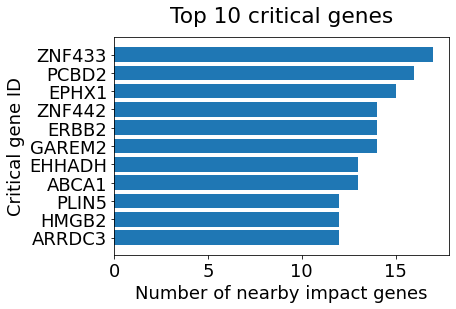

In [7]:
gene_set = plot_nearby_impact_num(converted_cg_df, 'Top 10 critical genes')

In [10]:
from src.eda.eda_functions import gene_set_phenotype_corr, run_kmeans, cluster_phenotype_corr, gene_phenotype_corr

## Plot alcohol trait and CG, neighbor and DEG correlation

In [4]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)

In [8]:
before19911 = expression_meta_df.columns[:19911].map(gene_mapping_dict)
after19911 = expression_meta_df.columns[19911:]
new_columns = list(before19911) + list(after19911)
expression_meta_df.columns = new_columns

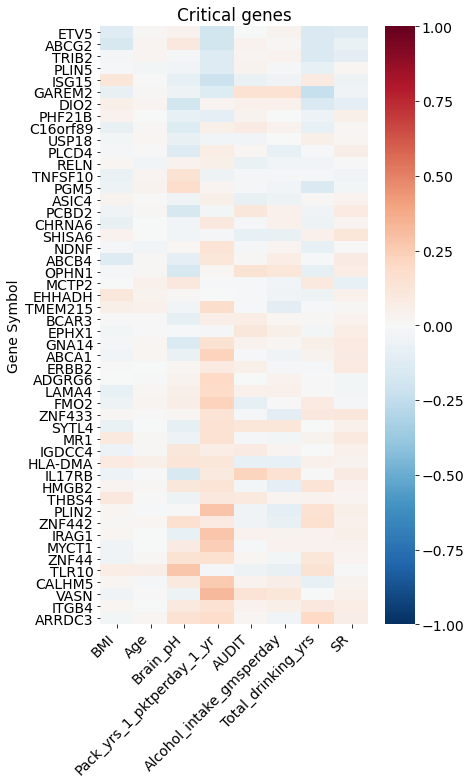

In [12]:
cg_corr = gene_phenotype_corr(converted_cg_df.gene[:50], expression_meta_df, 'Critical genes')

In [13]:
neighbors_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/top_830_neighbor_genes.csv')
neighbors_symbols = list(neighbors_df['gene'].map(gene_mapping_dict))

In [14]:
neighbors_symbols = [symbol for symbol in neighbors_symbols if type(symbol) == str]

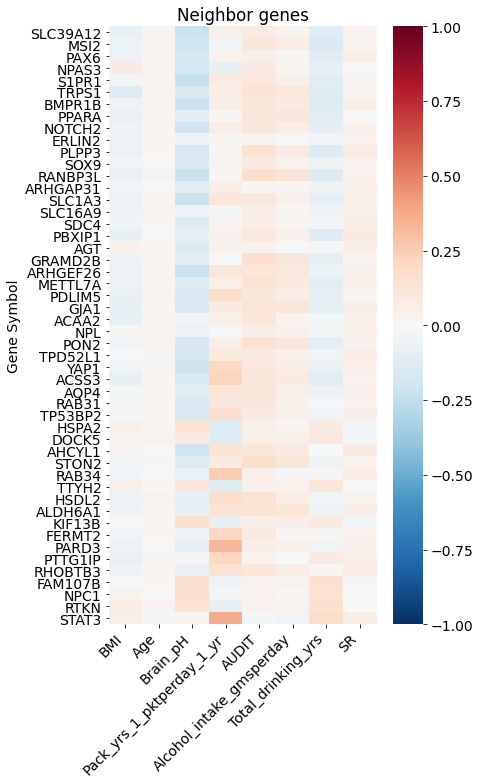

In [15]:
neighbor_corr = gene_phenotype_corr(neighbors_symbols[:50], expression_meta_df, 'Neighbor genes')

In [16]:
deseq = pd.read_excel(prefix + '/Shared drives/NIAAA_ASSIST/Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])
deseq.sort_values('abs_log2FC', ascending = False, inplace = True)

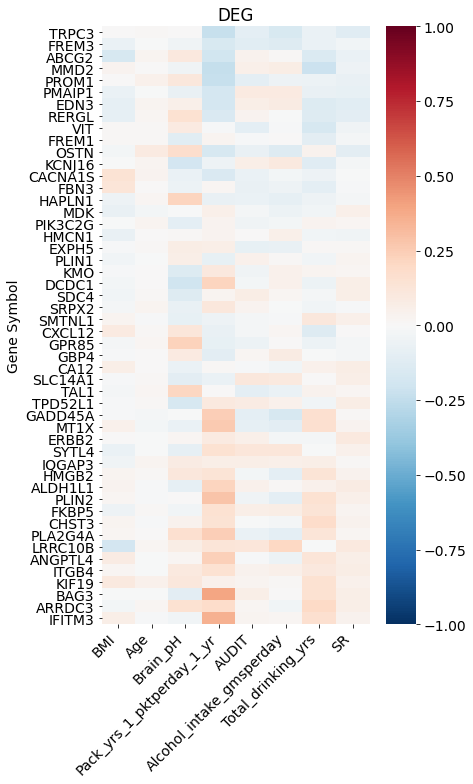

In [17]:
deg_corr = gene_phenotype_corr(deseq.gene[:50], expression_meta_df, 'DEG')

In [28]:
def plot_corr_dist(corr_df, sample_name, trait):
    plt.rcParams.update({'font.size':18})
    sns.kdeplot(corr_df, label = sample_name)
#     sns.kdeplot((corr_df).values.flatten(), label = sample_name)
#     plt.xlim(0, 1)
    plt.title(trait)
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Events')
    plt.legend()

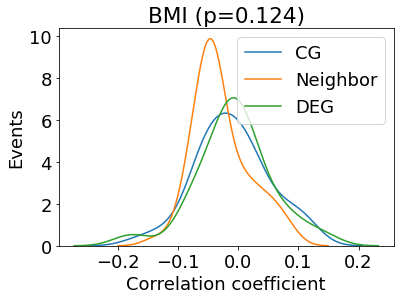

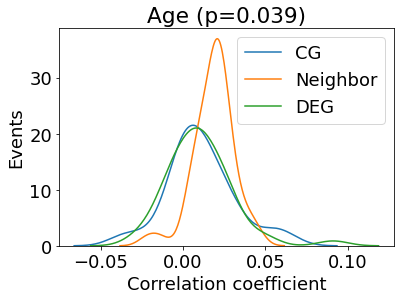

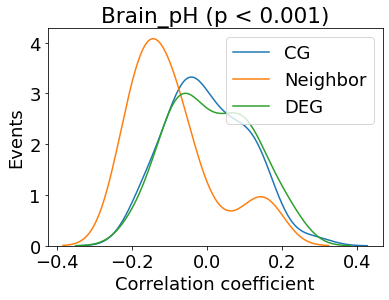

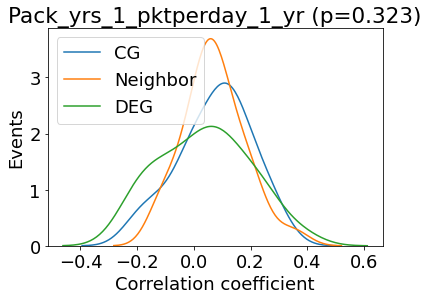

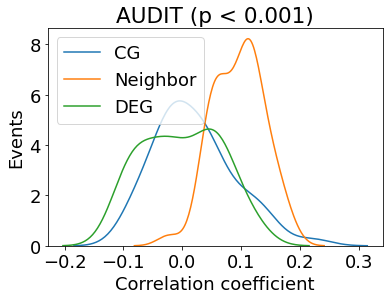

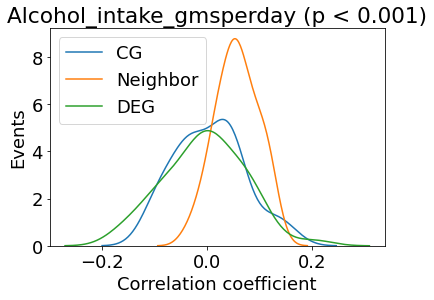

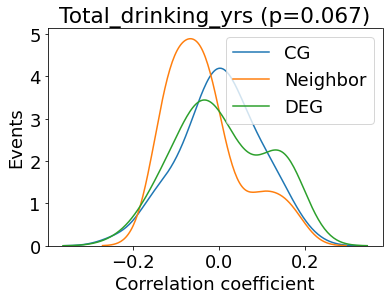

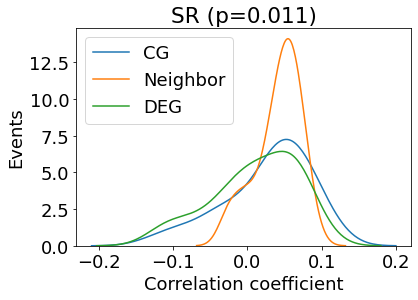

In [80]:
for col in cg_corr.columns:
    cg_values = cg_corr[col]
    neighbor_values = neighbor_corr[col]
    deg_values = deg_corr[col]
    anova_pvalue = f_oneway(cg_values, neighbor_values, deg_values)[1]
    plot_dist(cg_values, 'CG', '', 'correlation')
    plot_dist(neighbor_values, 'Neighbor', '', 'correlation')
    round_p = round(anova_pvalue, 3) 
    plot_dist(deg_values, 'DEG', f'{col} (p={round_p})' if round_p > 0 else f'{col} (p < 0.001)', 'correlation')
    plt.show()
    plt.close()